In [15]:
import re
import numpy as np
import codecs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os
import plotly.graph_objects as go

n_digits = 8


In [16]:


def extract_addition_problems(file_path, n_digits, m_digits):
    """
    Extracts addition problems from a .pkl file where the first term has `n_digits` digits 
    and the second term has `m_digits` digits, then returns them as tuples.
    Excludes specific problems.

    Args:
        file_path (str): The path to the .pkl file containing the problems.
        n_digits (int): Number of digits in the first term.
        m_digits (int): Number of digits in the second term.

    Returns:
        List of tuples: List of valid problems, each as (term1, term2, predicted_result, correct_result).
    """
    
    # Exclude example problems
    exclude_problems = [(100, 200, 300), (520, 890, 1410), (100, 100, 200)]
    problems = []

    # Use codecs.open to safely handle non-UTF-8 characters with 'ignore'
    try:
        with codecs.open(file_path, 'r', 'utf-8', 'ignore') as file:
            for line in file:
                # Pattern of addition problems
                ptrn = r"(-?\d+)\s+\+\s+(-?\d+)\s=\s(-?\d+)"
                srch = re.search(ptrn, line.strip())

                if srch is not None:
                    term1 = int(srch.group(1))
                    term2 = int(srch.group(2))
                    predicted_result = int(srch.group(3))
                    correct_result = term1 + term2

                    # Check if the terms match n_digits and m_digits and exclude the example problems
                    if len(str(abs(term1))) == n_digits and len(str(abs(term2))) == m_digits:
                        if (term1, term2, predicted_result) not in exclude_problems:
                            problems.append((term1, term2, predicted_result, correct_result))

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    
    return problems


In [8]:


# Loss function (Mean Squared Error)
def mse_loss(problems):
    """
    Calculates the MSE between the predicted results and the correct results.

    Args:
        problems (list): List of tuples (term1, term2, predicted_result, correct_result)

    Returns:
        float: Mean squared error
    """
    squared_errors = [(pred - correct) ** 2 for _, _, pred, correct in problems]
    return np.mean(squared_errors)


In [9]:


def plot_loss_landscape(X, Y, Z, i, j, k, output_path):
    """
    Plots a loss landscape for a sample of all combinations of i-digit by j-digit problems
    against their mean squared error (Z) under a given temperature k.  Saves the plot
    to the given output_path.

    Args:
        X (NDArray): array of 1 to i to represent x-axis.
        Y (NDArray): array of 1 to j to represent y-axis.
        Z (NDArray): array of the MSEs of each combination of X and Y.
        i (int): number of digits in first term in addition problem.
        j (int): number of digits in second term in addition problem.
        k (float): temperature passed to LLM.
        output_path (str): path to directory where user would like to save the plot.

    Returns:
        A saved loss landscape for the given parameters in the given output directory.
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create the surface plot
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Set axis labels
    ax.set_xlabel('Digits in First Term')
    ax.set_ylabel('Digits in Second Term')
    ax.set_zlabel('MSE Loss')

    # Set the title
    ax.set_title(f'Loss Landscape for all problems within {i} by {j}-digits at temperature {k:.1f}')
    
    # Ensure the directory exists before saving the plot
    os.makedirs(output_path, exist_ok=True)
    
    # Save the plot as a PNG file
    plt.savefig(os.path.join(output_path, f"static_loss_landscape_at_{k:.1f}.png"))
    plt.close()


In [ ]:


if __name__ == "__main__":
    """
    Creates an interactive, 3D loss landscape for the LLM's ln(MSE) of all combinations of 8x8 addition problems.
    """

    # Temperatures from 0.0 to 2.0
    temperatures = np.arange(0, 2.1, 0.1)

    # Size of n
    n = 8

    # Set output directory for the current temperature
    output_dir = "loss_landscapes"
    os.makedirs(output_dir, exist_ok=True)

# Loop over temperatures
for k in temperatures:
    # Initialize Z as an nxn matrix to store log MSE values
    xZ = np.zeros((n, n))  

    # Loop over all digit combinations from 1-digit to n-digit
    for i in range(1, n+1):
        for j in range(1, n+1):
            # Always use the larger digit number's folder
            folder = f"{max(i, j)}_results"
            x_file_path = f"{folder}/{i}_by_{j}_results/{i}_by_{j}_at_{k:.1f}_results.pkl"
            y_file_path = f"{folder}/{j}_by_{i}_results/{j}_by_{i}_at_{k:.1f}_results.pkl"

            # Extract i-digit by j-digit problems
            x_problems = extract_addition_problems(x_file_path, i, j)
            y_problems = extract_addition_problems(y_file_path, j, i)

            # print("accessing " + x_file_path)
            # print("accessing " + y_file_path)

            # Calculate MSE loss for both MSEx and MSEy problems
            x_mse = mse_loss(x_problems)
            y_mse = mse_loss(y_problems)
            
            # print("ij = " + str(x_mse))
            # print("ji = " + str(y_mse))

            # Calculate ln(MSE)
            log_mse_i_j = np.log(x_mse + 1e-10)
            log_mse_j_i = np.log(y_mse + 1e-10)

            # print("log ij = " + str(log_mse_i_j))
            # print("log ji = " + str(log_mse_j_i))

            # Fill the upper triangle (i < j) with ln(MSEy)
            if i < j:
                xZ[i-1, j-1] = log_mse_i_j

            # Fill the lower triangle (i > j) with ln(MSEx)
            elif i > j:
                xZ[i-1, j-1] = log_mse_j_i

            # Fill the diagonal (i = j) with the one of the ln(MSE) since they will be equal
            elif i == j:
                xZ[i-1, j-1] = log_mse_i_j

    # After collecting MSE values for all i-by-j and j-by-i combinations at this temperature, plot the landscape
    if xZ.size == (n**2):  # Ensure Z is a full nxn matrix
        X_grid, Y_grid = np.meshgrid(np.arange(1, 9), np.arange(1, 9))  # Full 8x8 grid

        # Plot and save the loss landscape for this temperature
        plot_loss_landscape(X_grid, Y_grid, xZ, 8, 8, k, output_dir)
        # print(f"creating static {k:.1f} landscape")

        # Create an interactive 3D surface plot using Plotly
        fig = go.Figure(data=[go.Surface(z=xZ, x=X_grid, y=Y_grid, colorscale='Viridis')])

        # Update layout for interactive viewing
        fig.update_layout(scene=dict(
                            xaxis_title='Digits in First Term',
                            yaxis_title='Digits in Second Term',
                            zaxis_title='Ln(MSE)'),
                            title=f"Interactive Loss Landscape for Temperature {k:.1f}",
                            autosize=False,
                            width=700, height=700)

        # Show the interactive plot
        # fig.show()

        # Save the interactive plot as an HTML file
        fig.write_html(f"{output_dir}/interactive_loss_landscape_at_{k:.1f}.html")
        
        # print(f"Creating interactive {k:.1f} landscape")
        
    # else:
    #     print(f"Warning: Temperature {k:.1f} does not have {n**2} MSE values. Skipping plot.")





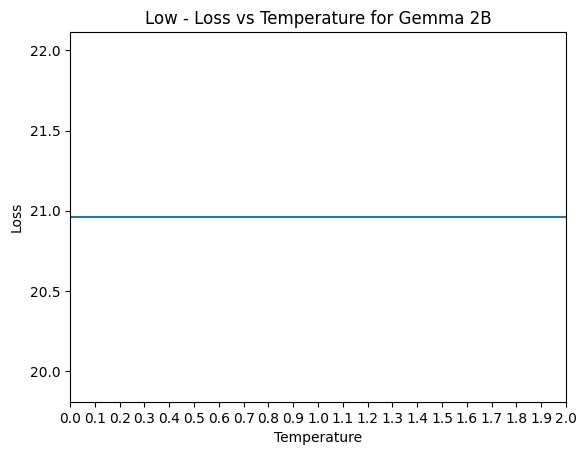

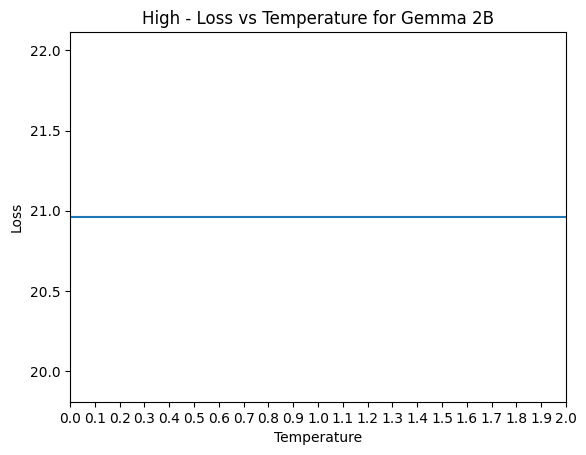

In [23]:

"""
Creates a plot of average ln(MSE) across all combinations of nxn addition problems against different temperatures.
"""

# Initialize variables
temperatures = np.arange(0, 2.1, 0.1)
xZ = []
yZ = []
n = 8

# Loop over temperatures
for k in temperatures:
    x_log_mse_values = []
    y_log_mse_values = []

    # Loop over all digit combinations from 1-digit to n-digit
    for i in range(1, n+1):
        for j in range(1, n+1): 
            # Always use the larger digit number's folder
            folder = f"{max(i, j)}_results"
            x_file_path = f"{folder}/{i}_by_{j}_results/{i}_by_{j}_at_{k:.1f}_results.pkl"
            y_file_path = f"{folder}/{j}_by_{i}_results/{j}_by_{i}_at_{k:.1f}_results.pkl"

            # print("accessing " + x_file_path)
            # print("accessing " + y_file_path)

            # Extract i-digit by j-digit problems
            x_problems = extract_addition_problems(x_file_path, i, j)
            y_problems = extract_addition_problems(y_file_path, j, i)

            # print(x_problems)
            # print(y_problems)

            # Calculate MSEx and MSEy
            x_mse = mse_loss(x_problems)
            y_mse = mse_loss(y_problems)

            # print(x_mse)
            # print(y_mse)

            # Calculate the ln(MSE)
            log_x_mse = np.log(x_mse + 1e-10)
            log_y_mse = np.log(y_mse + 1e-10)

            # print(log_x_mse)
            # print(log_y_mse)

            # Add values to list
            x_log_mse_values.append(log_x_mse)
            y_log_mse_values.append(log_y_mse)
    
    # Average of MSEx at temperature k
    x_avg_log_mse = np.mean(x_log_mse_values)
    xZ.append((k, x_avg_log_mse))

    # Acerage of MSEy at temperature k
    y_avg_log_mse = np.mean(y_log_mse_values)
    yZ.append((k, y_avg_log_mse))

# Extract temperatures and corresponding losses
x_temps_for_plot = [item[0] for item in xZ] 
x_losses_for_plot = [item[1] for item in xZ] 

y_temps_for_plot = [item[0] for item in yZ]  
y_losses_for_plot = [item[1] for item in yZ]  

# print(xZ)
# print(yZ)

# Plot x MSE
plt.figure()
plt.plot(y_temps_for_plot, y_losses_for_plot)
plt.xlim(0, 2)
plt.xticks(np.arange(0, 2.1, 0.1))
plt.xlabel('Temperature')
plt.ylabel('Loss')
plt.title('Low - Loss vs Temperature for Gemma 2B')
plt.savefig("loss_landscapes/Low_loss_vs_temp.png")

# Plot y MSE
plt.figure()
plt.plot(x_temps_for_plot, x_losses_for_plot)
plt.xlim(0, 2)
plt.xticks(np.arange(0, 2.1, 0.1))
plt.xlabel('Temperature')
plt.ylabel('Loss')
plt.title('High - Loss vs Temperature for Gemma 2B')
plt.savefig("loss_landscapes/High_loss_vs_temp.png")


In [17]:
def generate_latex_table(com_mse):
    """
    Generates a LaTeX table from the com_mse list
    """
    latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n"
    latex_table += "Digit & Combination & Log MSE Values \\\\ \n\\hline\n"
    
    # Loop through the com_mse list and generate LaTeX table rows
    current_digit = None
    for (x_file, log_x_mse, y_file, log_y_mse) in com_mse:
        digit = int(x_file.split('_')[0])  # Extract the digit (e.g., "3" from "3_by_1")
        
        if current_digit is None or current_digit != digit:
            current_digit = digit
            latex_table += f"\\textbf{{{current_digit}}} & {x_file} & ({log_x_mse:.4f}, {log_y_mse:.4f}) \\\\ \n"
        else:
            latex_table += f" & {x_file} & ({log_x_mse:.4f}, {log_y_mse:.4f}) \\\\ \n"
    
    latex_table += "\\hline\n\\end{tabular}\n\\caption{Log MSE values for digit combinations}\n\\end{table}"
    
    return latex_table

In [ ]:

"""
Creates an LaTeX table of the ln(MSE) values for all combinations of x and y digit addition problems.
"""

# initialize variables
com_mse = []
k = 1.0
x_log_mse_values = []
y_log_mse_values = []
n = 8

# Loop over all digit combinations from 1-digit to n-digit
for i in range(1, n+1):
    for j in range(0, i):
        if j == 1:
            continue
        if j == 0:
            j += 1
        
        # Always use the larger digit number's folder
        folder = f"{max(i, j)}_results"
        x_file_path = f"{folder}/{i}_by_{j}_results/{i}_by_{j}_at_{k:.1f}_results.pkl"
        x_file = f"{i}_by_{j}"

        y_file_path = f"{folder}/{j}_by_{i}_results/{j}_by_{i}_at_{k:.1f}_results.pkl"
        y_file = f"{j}_by_{i}"

        # print("accessing " + x_file_path)
        # print("accessing " + y_file_path)

        # Extract i-digit by j-digit problems
        x_problems = extract_addition_problems(x_file_path, i, j)
        y_problems = extract_addition_problems(y_file_path, j, i)

        # Calculate MSE loss for both normal and reverse problems
        x_mse = mse_loss(x_problems)
        y_mse = mse_loss(y_problems)

        # Calculate the average MSE
        log_x_mse = np.log(x_mse + 1e-10)
        log_y_mse = np.log(y_mse + 1e-10)

        # print(log_x_mse)
        # print(log_y_mse)

        com_mse.append((x_file, log_x_mse, y_file, log_y_mse))
 
# print(com_mse)

            
# Generate and print LaTeX table
latex_table_output = generate_latex_table(com_mse)
print(latex_table_output)
    
    